## ABOUT

- reframing as 17 bucket categorization problem
- accuracy is terrible.  notebook is a hacked up mess

---
- Best MAE: 
- LB Score:

## SETUP

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.vision import *
from fastai.callbacks import *

In [3]:
# show versions
print('fastai:', fastai.__version__)
print('pytorch:', torch.__version__)
print('python:', sys.version.split(' ')[0])

fastai: 1.0.50.post1
pytorch: 1.0.1.post2
python: 3.6.7


In [4]:
version = 'v11'       # this should match the notebook filename

seed = 42
arch = models.resnet50
size = (128, 384)
bs = 16
num_workers = 8     # set to available cores

scale = 1           # number to divide y by to help normalize values
transform = 'mel'  # which time series to visual transformation to use

In [5]:
# set seed
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## DATA

Assumes the following has been generated using `gen_spectrogram`:
- `X_train.csv`
- `y_train.csv`
- `train_images`
- `test_images`

In [6]:
# set paths
path = pathlib.Path.home()/'.fastai/data/kaggle_earthquake'
img_path = path/f'train_images/{transform}'
save_path = path/'saved_models'
os.makedirs(save_path, exist_ok=True)

In [7]:
# load segment CSVs
#pd.options.display.precision = 15
X_train = pd.read_csv(path/'X_train.csv', index_col=0)
y_train = pd.read_csv(path/'y_train.csv', index_col=0)

In [8]:
#X_train.head()

In [9]:
y_train.head()

,time_to_failure
0,1.430797
1,1.391499
2,1.353196
3,1.313798
4,1.274400


min: 0.0063976571678
max: 16.103195567


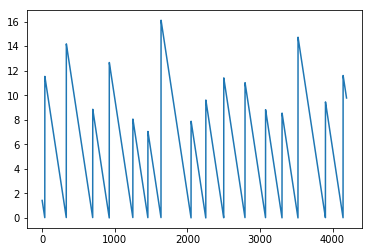

In [10]:
# graph y_train
print('min:', min(y_train['time_to_failure']))
print('max:', max(y_train['time_to_failure']))
plt.plot(y_train)

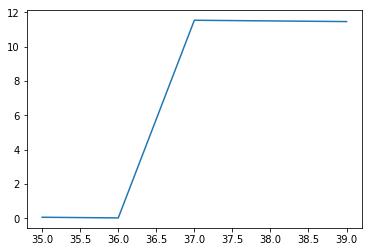

In [11]:
# find a segment with an earthquake
plt.plot(y_train[35:40])

In [12]:
y_train[35:40]

,time_to_failure
35,0.066798
36,0.028496
37,11.530097
38,11.490799
39,11.452496


## MODEL

In [13]:
# scale down the labels
def gen_label(path):
    id = int(path.name.split('_')[1].split('.')[0])
    ttf = y_train.iloc[id]['time_to_failure']
    return int(round(ttf / scale))

In [14]:
# unscaled is 1.4307971859
gen_label(img_path/'seg_0.png')

1

In [15]:
# no data augmentation
tfms = get_transforms(do_flip=False, p_affine=0., p_lighting=0.)

In [16]:
fake_label = 0
#valid_idx = range(3000, len(y_train))

src = (ImageList.from_folder(img_path)
        .split_by_rand_pct(valid_pct=0.30)
        .label_from_func(gen_label)
        .add_test_folder(f'../../test_images/{transform}', label=fake_label))

In [17]:
# pre-trained resnet
data = (src.transform(tfms, resize_method=ResizeMethod.NO, size=size)
        .databunch(bs=bs, num_workers=num_workers)
        .normalize(imagenet_stats))

In [ ]:
# custom CNN
data = (src.transform(tfms, resize_method=ResizeMethod.SQUISH, size=size)
        .databunch(bs=bs, num_workers=num_workers))

In [18]:
# verify datasets loaded properly
n_train_items = len(data.train_ds)
n_valid_items = len(data.valid_ds)
n_test_items = len(data.test_ds)

print('train: ', n_train_items)
print('valid: ', n_valid_items)
print('test:  ', n_test_items)
print('')
print('TOTAL: ', n_train_items + n_valid_items + n_test_items)

train:  2936
valid:  1258
test:   2624

TOTAL:  6818


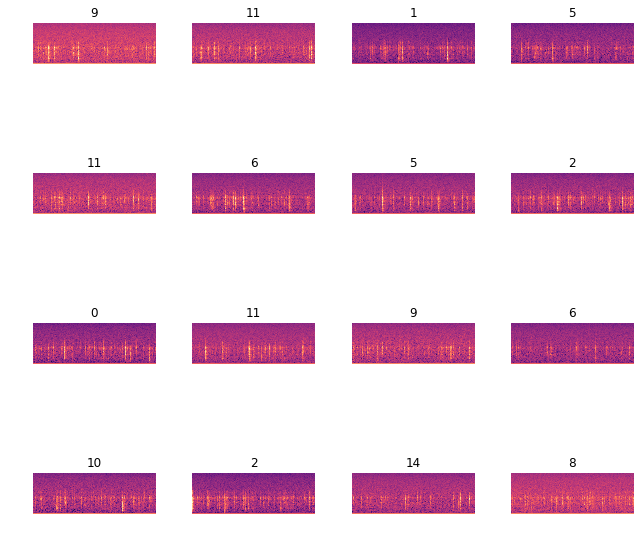

In [19]:
# verify images and labels match up
data.show_batch(4, figsize=(9, 9))

In [20]:
# define metrics
def mae_scaled(preds, targs):
    return mean_absolute_error(preds.view(-1)*scale, targs.view(-1)*scale)

def mse_scaled(preds, targs):
    return mean_squared_error(preds.view(-1)*scale, targs.view(-1)*scale)

In [21]:
# L1 loss is sum of the all the absolute differences
# more robust to outliers
l1loss = nn.L1Loss()
def l1_loss(preds, targs):
    return l1loss(preds.view(-1), targs.view(-1))

# L2 loss is sum of the all the squared differences
# less robust to outliers
l2loss = nn.MSELoss()
def l2_loss(preds, targs):
    return l2loss(preds.view(-1), targs.view(-1))

In [22]:
# return correct size of fully connected layer based on pre-trained model
def final_conv_layer_size(arch):
    if arch == models.resnet50 and size == 224: return 2048*7*7
    elif arch == models.resnet50 and size == 384: return 2048*12*12
    elif arch == models.resnet50 and size == (128,384): return 2048*4*12

In [23]:
# define custom heads
small_head = nn.Sequential(Flatten(), nn.Linear(final_conv_layer_size(arch), 1))

small_head_sigmoid = nn.Sequential(Flatten(), nn.Linear(final_conv_layer_size(arch), 1),  nn.Sigmoid())

medium_head = nn.Sequential(
  nn.AvgPool2d((4, 12)),
  Flatten(), 
  nn.BatchNorm1d(2048),
  nn.Dropout(0.5),
  nn.Linear(2048, 256),
  nn.ReLU(),
  nn.BatchNorm1d(256),
  nn.Dropout(0.5),
  nn.Linear(256, 1))

big_head = nn.Sequential(
  nn.AvgPool2d((4, 12)),
  Flatten(), 
  nn.BatchNorm1d(2048),
  nn.Dropout(0.5),
  nn.Linear(2048, 512),
  nn.ReLU(),
  nn.BatchNorm1d(512),
  nn.Dropout(0.5),
  nn.Linear(512, 128),
  nn.ReLU(),
  nn.BatchNorm1d(128),
  nn.Dropout(0.5),
  nn.Linear(128, 1))


big_head_sigmoid = nn.Sequential(
  nn.AvgPool2d((4, 12)),
  Flatten(), 
  nn.BatchNorm1d(2048),
  nn.Dropout(0.5),
  nn.Linear(2048, 512),
  nn.ReLU(),
  nn.BatchNorm1d(512),
  nn.Dropout(0.5),
  nn.Linear(512, 128),
  nn.ReLU(),
  nn.BatchNorm1d(128),
  nn.Dropout(0.5),
  nn.Linear(128, 1),
  nn.Sigmoid())

In [ ]:
# custom models
conv1d_model = nn.Sequential(
    nn.Conv1d(1, 8, kernel_size=10, stride=10),    # 15_000
    nn.BatchNorm1d(15000),
    nn.ReLU(),
    nn.Conv1d(8, 16, kernel_size=10, stride=10),   # 1_500
    nn.BatchNorm1d(1500),
    nn.ReLU(),
    nn.Conv1d(16, 32, kernel_size=10, stride=10),  # 150
    nn.BatchNorm1d(150),
    nn.ReLU(),
    Flatten(),
    #nn.AvgPool?
    nn.BatchNorm1d(150),
    nn.Dropout(0.5),
    nn.Linear(150, 16),
    nn.ReLU(),
    nn.BatchNorm1d(16),
    nn.Dropout(0.5),
    nn.Linear(16, 1))


def conv2d_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU())

def five_conv2d_blocks(c):
    return nn.Sequential(
        conv2d_block(3, c),
        conv2d_block(c, c*2),
        conv2d_block(c*2, c*4),
        conv2d_block(c*4, c*8),
        conv2d_block(c*8, c*16))

def linear_block(in_channels, out_channels):
    return nn.Sequential(
        nn.BatchNorm1d(in_channels),
        nn.Dropout(0.5),
        nn.Linear(in_channels, out_channels))

start_channels = 32
end_channels = start_channels * 16

conv2d_model = nn.Sequential(
    five_conv2d_blocks(start_channels),
    nn.AvgPool2d((4, 12)),
    Flatten(),
    linear_block(end_channels, 32),
    nn.ReLU(),
    linear_block(32, 1))

In [70]:
# resnet learner
learn = cnn_learner(data, arch,
                    loss_func=nn.CrossEntropyLoss(),
                    metrics=[accuracy])

In [ ]:
# custom CNN learner
learn = Learner(data, conv2d_model,
                    loss_func=l1_loss,
                    metrics=[mean_squared_error, mean_absolute_error, mse_scaled, mae_scaled])

In [59]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 192]        9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 192]        128        True      
______________________________________________________________________
ReLU                 [64, 64, 192]        0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 96]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 96]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 32, 96]         128        True      
______________________________________________________________________
Conv2d               [64, 32, 96]         36,864     False     
______________________________________________________________

## TRAIN

#### Helper functions

In [60]:
def plot_lr_find(learn):
    learn.lr_find()
    learn.recorder.plot()

In [61]:
def fit_one_cycle(learn, stage, n_epochs, max_lr):
    learn.fit_one_cycle(n_epochs, max_lr=max_lr, callbacks=[
        SaveModelCallback(learn,
                          monitor='mean_absolute_error',
                          mode='min',
                          every='improvement',
                          name=save_path/f'{version}-{stage}-best')])
    learn.recorder.plot_losses()
    learn.recorder.plot_lr(show_moms=True)

#### Stage 1.1

In [62]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


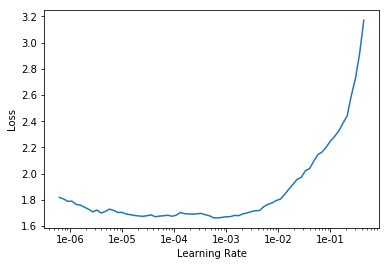

In [74]:
plot_lr_find(learn)

In [72]:
stage = 's1.1'
n_epochs = 6
max_lr = slice(1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.136846,2.785240,0.130366,00:14
1,2.735609,2.580827,0.127186,00:14
2,2.438447,2.577592,0.143084,00:14
3,2.156259,2.612667,0.153418,00:14
4,1.934145,2.561357,0.166137,00:14
5,1.765923,2.581746,0.170111,00:14


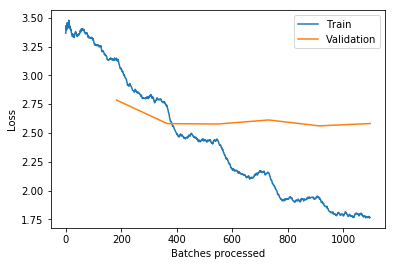

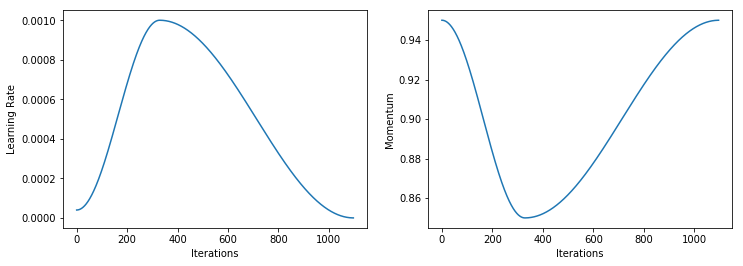

In [73]:
fit_one_cycle(learn, stage, n_epochs, max_lr)

#### Stage 1.2

In [ ]:
learn.load(save_path/f'{version}-s1.1-best');

In [75]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


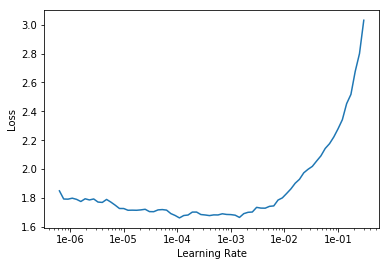

In [76]:
plot_lr_find(learn)

In [77]:
stage = 's1.2'
n_epochs = 20
max_lr = slice(1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.720579,2.586337,0.159777,00:14
1,1.731968,2.559269,0.158188,00:14
2,1.715370,2.594890,0.160572,00:14
3,1.683416,2.597461,0.156598,00:14
4,1.715076,2.612480,0.150238,00:14
5,1.619441,2.637267,0.156598,00:14
6,1.635305,2.644085,0.147059,00:14
7,1.540863,2.669240,0.150238,00:14
8,1.550723,2.647981,0.154213,00:15
9,1.507153,2.691534,0.151033,00:14


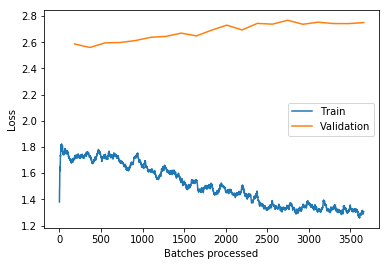

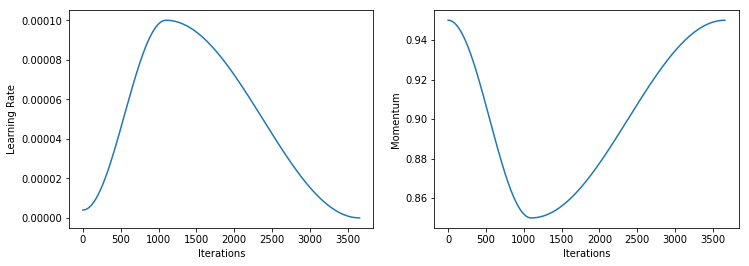

In [78]:
fit_one_cycle(learn, stage, n_epochs, max_lr)

#### Stage 2.1

In [ ]:
learn.load(save_path/f'{version}-s1.2-best');

In [79]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


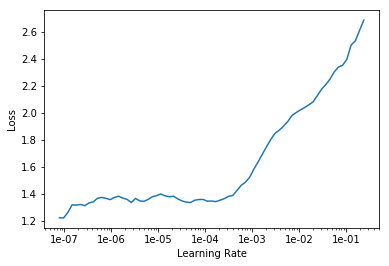

In [80]:
learn.lr_find(start_lr=1e-8)
learn.recorder.plot()

In [81]:
stage = 's2.1'
n_epochs = 20
max_lr = slice(2e-6, 2e-5)

epoch,train_loss,valid_loss,accuracy,time
0,1.288647,2.740543,0.151033,00:19
1,1.286284,2.762536,0.147854,00:19
2,1.312989,2.779350,0.155008,00:20
3,1.200857,2.727875,0.158983,00:20
4,1.139400,2.746499,0.147854,00:20
5,1.028899,2.810292,0.152623,00:20
6,0.832033,2.827568,0.156598,00:20
7,0.757044,2.826319,0.151033,00:19
8,0.653401,2.879606,0.142289,00:20
9,0.554950,2.849040,0.150238,00:20


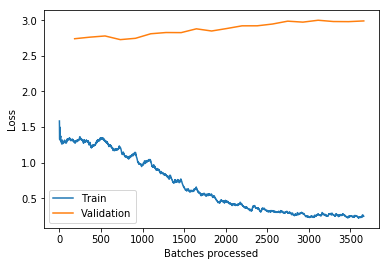

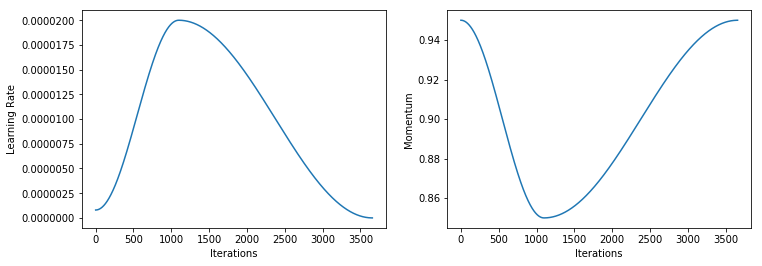

In [82]:
fit_one_cycle(learn, stage, n_epochs, max_lr)

#### Stage 2.2

In [ ]:
learn.load(save_path/f'{version}-s2.1-best');

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find(start_lr=1e-8)
learn.recorder.plot()

In [ ]:
stage = 's2.2'
n_epochs = 6
max_lr = slice(2e-7, 2e-6)

In [ ]:
fit_one_cycle(learn, stage, n_epochs, max_lr)

## RESULTS

In [ ]:
learn.load(save_path/f'{version}-s1.2-best');

In [42]:
# plot histograms of results
def plot_results(dataset):
    preds, targs = learn.get_preds(ds_type=dataset)
    preds = preds.float() * scale
    targs = targs.float() * scale
    print(preds.shape)
    print('min/max pred: ', min(preds.argmin(dim=1)).item(), max(preds.argmax(dim=1)).item())
    print('min/max targ: ', min(targs.argmin(dim=1)).item(), max(targs.argmax(dim=1)).item())
    fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
    ax1.hist(preds.squeeze(), bins=50); ax1.set_xlabel('TTF'); ax1.set_ylabel('preds')
    ax2.plot(preds); ax2.set_xlabel('segment')
    ax3.hist(targs, bins=50); ax3.set_xlabel('TTF'); ax3.set_ylabel('targs')
    ax4.plot(targs); ax4.set_xlabel('segment')

#### Training Set

In [35]:
plot_results(DatasetType.Fix)

RuntimeError: bool value of Tensor with more than one value is ambiguous

#### Validation Set

In [43]:
plot_results(DatasetType.Valid)

torch.Size([1258, 17])
min/max pred:  0 16


RuntimeError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

#### Test Set

In [ ]:
plot_results(DatasetType.Test)

## SUBMISSION

In [ ]:
test_preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
# load sample submission
submission = pd.read_csv(path/'sample_submission.csv', index_col='seg_id')

In [ ]:
# assume order of test set is unchanged
submission['time_to_failure'] = [test_preds[i].item() * scale for i in range(len(test_preds))]

In [ ]:
submission.head()

In [ ]:
submission_file = path/f'{version}-submission.csv'
submission.to_csv(submission_file)

In [ ]:
# submit to leaderboard
#! cd $path; kaggle competitions submit -c LANL-Earthquake-Prediction -f $submission_file -m "Message"